## Read an XES file and Discover a BPMN process

In [1]:
import pandas as pd
import pm4py
import random
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from scipy import stats
import networkx as nx

### Convert XES to CSV file

### taking only 10% of the data set since its size is too large for our computers to analyze

In [14]:
df_original = pd.read_csv('./BPIChallenge2017.csv')
df_original = df_original.drop(columns=['Unnamed: 0', 'lifecycle:transition', 'case:ApplicationType', 'OfferID', 'FirstWithdrawalAmount'])

df_original['EventOrigin'] = df_original['EventOrigin'].replace({'Application': 'A', 'Workflow': 'W', 'Offer': 'O'})

df_original['time:timestamp'] = pd.to_datetime(df_original['time:timestamp'], errors='coerce')

df_original = df_original[df_original['concept:name'] != df_original['concept:name'].shift()]

df_original['offersDeclined'] = df_original[df_original['concept:name'] == 'O_Create Offer'].groupby('case:concept:name').cumcount()

offer_attributes_df = df_original[df_original['concept:name'] == 'O_Create Offer'].copy()
offer_attributes_df.set_index('case:concept:name', inplace=True)
offer_attributes_df = offer_attributes_df[['OfferedAmount', 'CreditScore', 'case:RequestedAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected', 'case:LoanGoal','time:timestamp', 'offersDeclined']]

df_original = df_original.drop(columns=['OfferedAmount', 'CreditScore', 'case:RequestedAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected'])


offer_attributes_df['offersDeclined'] = offer_attributes_df['offersDeclined'].fillna(0)

offer_attributes_df['requestedOfferedRatio'] = offer_attributes_df['OfferedAmount'] / offer_attributes_df['case:RequestedAmount']

offer_attributes_df.reset_index(inplace=True)

# df_original.to_csv('BPI2017.csv', index=False)
# offer_attributes_df.to_csv('BPIattributes.csv', index=False)

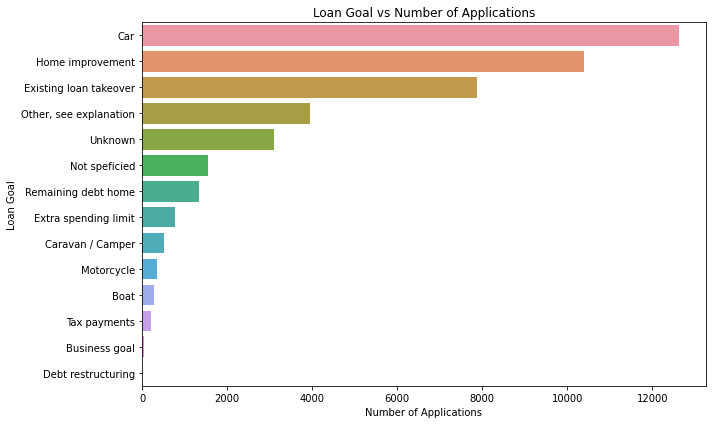

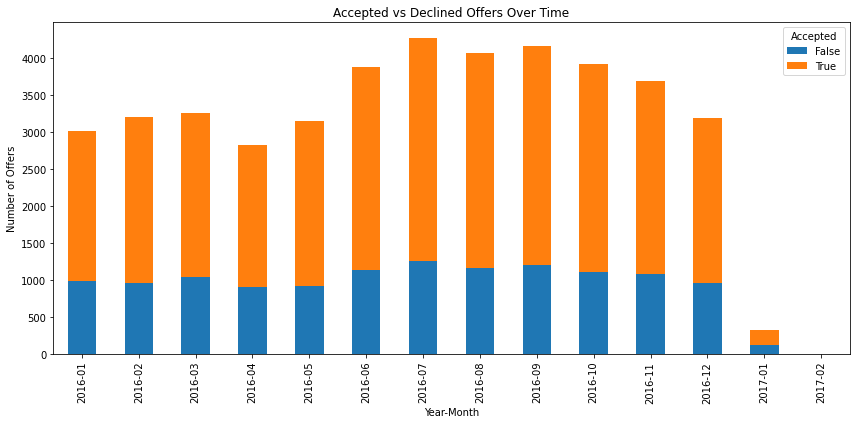

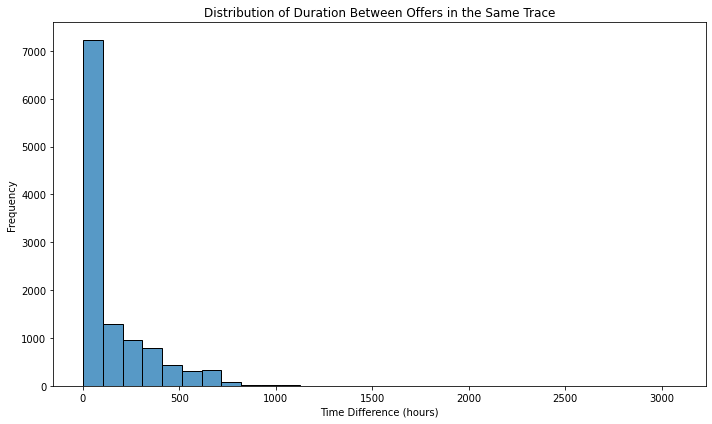

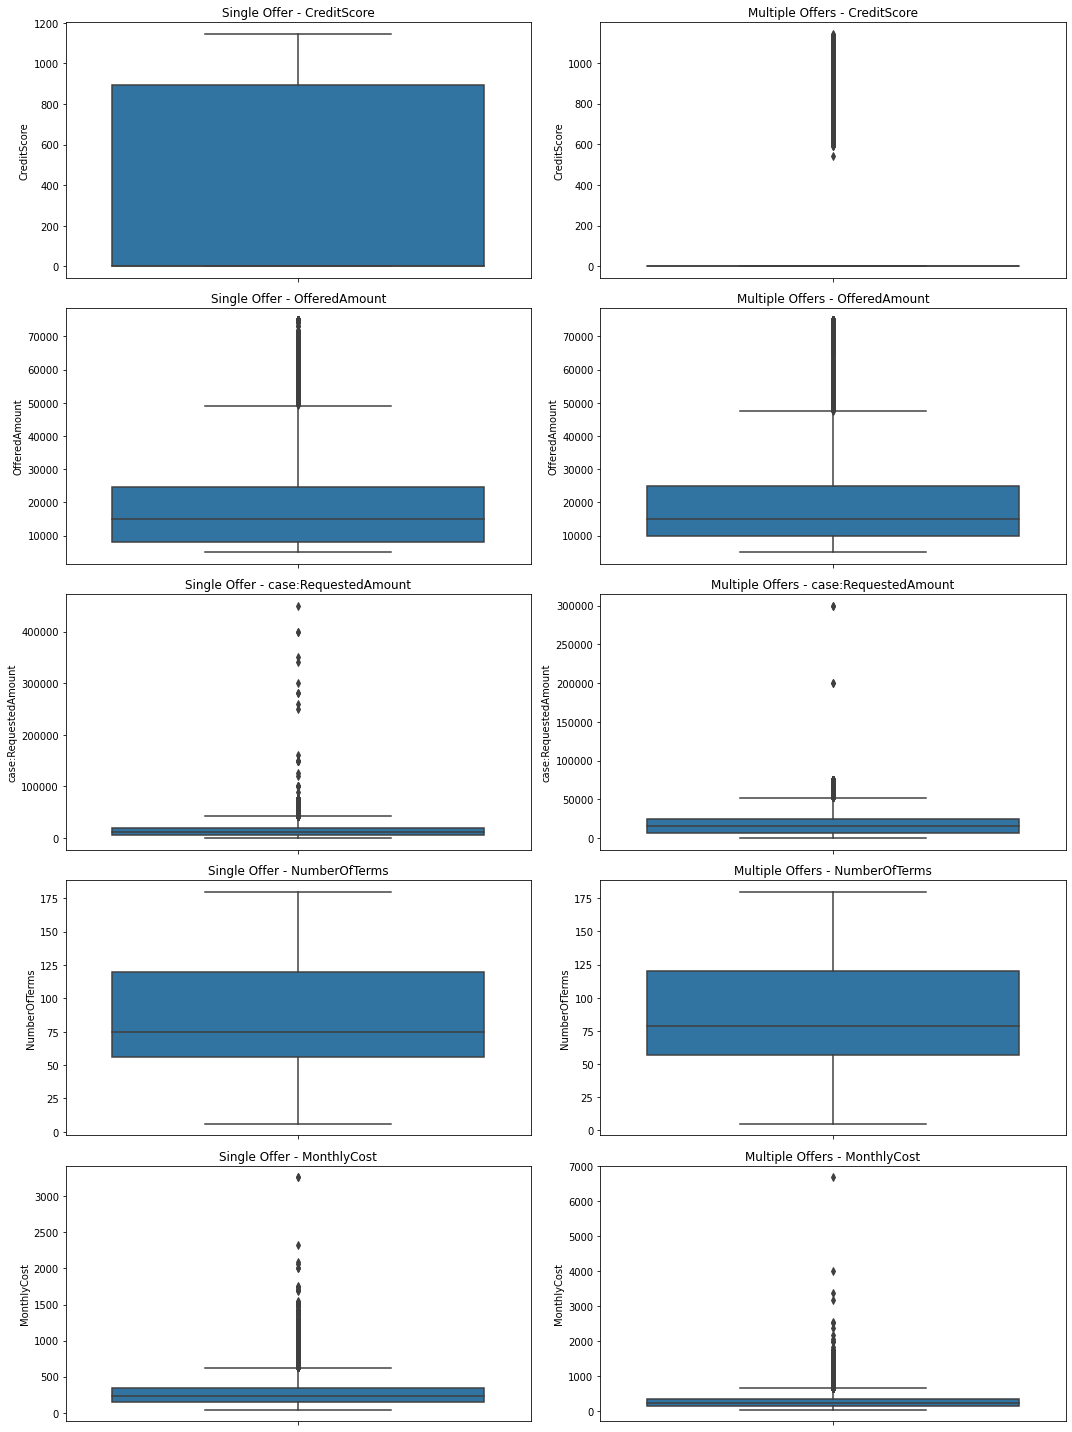

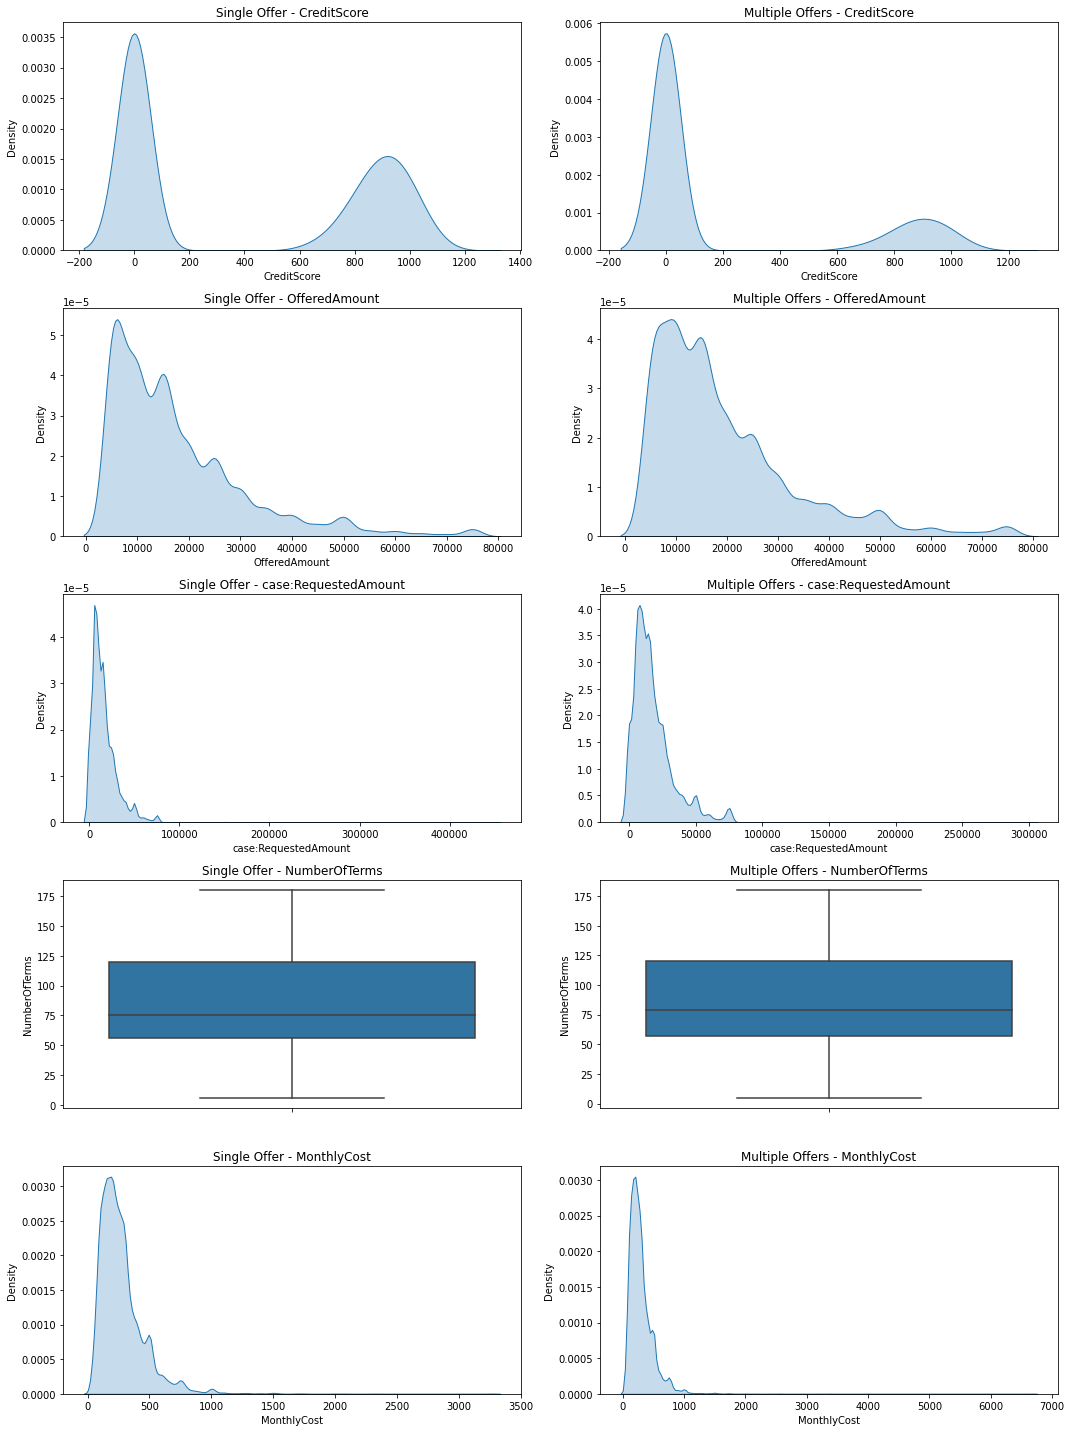

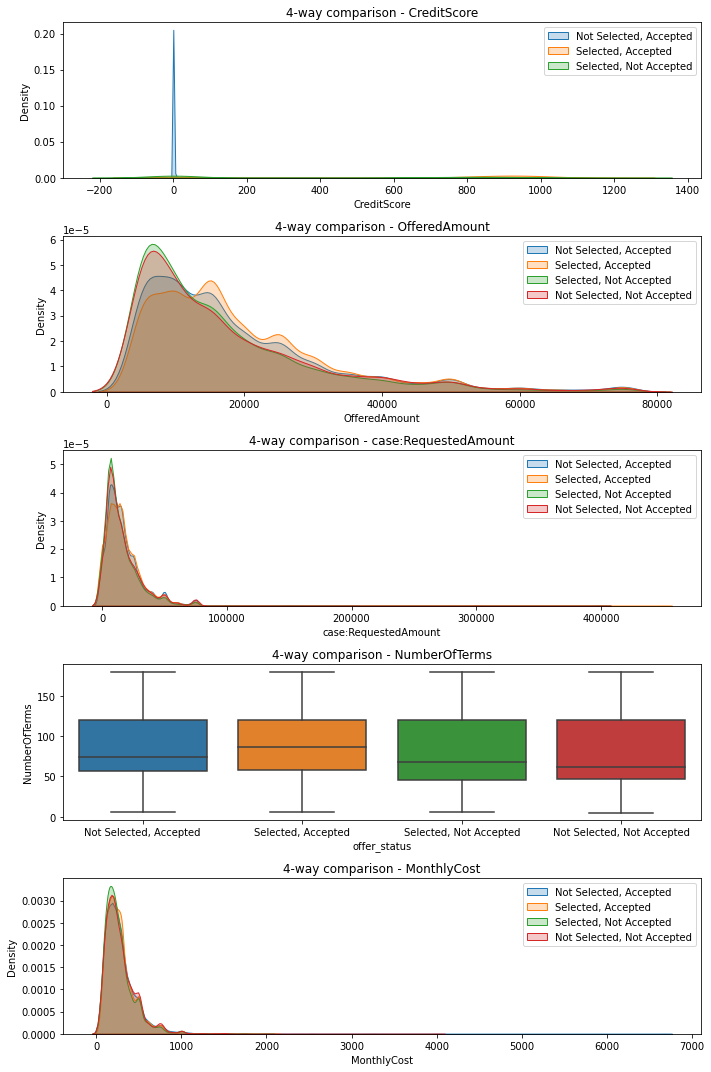

In [15]:
df = offer_attributes_df
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])

# Sort data by timestamp
df = df.sort_values('time:timestamp')

# Visualization 1: Loan Goal vs Number of Applications
plt.figure(figsize=(10, 6))
sns.countplot(y='case:LoanGoal', data=df, order = df['case:LoanGoal'].value_counts().index)
plt.title('Loan Goal vs Number of Applications')
plt.xlabel('Number of Applications')
plt.ylabel('Loan Goal')
plt.tight_layout()
plt.show()

# Visualization 2: Accepted vs Declined Offers over time
df['year-month'] = df['time:timestamp'].dt.to_period('M')
accepted_declined_over_time = df.groupby(['year-month', 'Accepted']).size().unstack(fill_value=0)

ax = accepted_declined_over_time.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Accepted vs Declined Offers Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Offers')
plt.tight_layout()
plt.show()

df = df.sort_values(['case:concept:name', 'time:timestamp'])
df['time_diff'] = df.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds() / 3600  # in hours

# Plot the distribution of time difference
plt.figure(figsize=(10, 6))
sns.histplot(df['time_diff'].dropna(), kde=False, bins=30)
plt.title('Distribution of Duration Between Offers in the Same Trace')
plt.xlabel('Time Difference (hours)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Visualization 5: Comparison of applications that had only 1 offer and applications that had more than one offer
df['offer_counts'] = df.groupby('case:concept:name')['case:concept:name'].transform('count')
single_offer_df = df[df['offer_counts'] == 1]
multi_offer_df = df[df['offer_counts'] > 1]

features = ['CreditScore', 'OfferedAmount', 'case:RequestedAmount', 'NumberOfTerms', 'MonthlyCost']
fig, axs = plt.subplots(len(features), 2, figsize=(15, 20))
for i, feature in enumerate(features):
    sns.boxplot(ax=axs[i, 0], y=single_offer_df[feature])
    axs[i, 0].set_title(f'Single Offer - {feature}')
    sns.boxplot(ax=axs[i, 1], y=multi_offer_df[feature])
    axs[i, 1].set_title(f'Multiple Offers - {feature}')
plt.tight_layout()
plt.show()

# Visualization 6: 4-way comparison of each offer
df['offer_status'] = df.apply(lambda row: 'Selected, Accepted' if row['Selected'] and row['Accepted'] else 
                              ('Not Selected, Accepted' if not row['Selected'] and row['Accepted'] else 
                               ('Selected, Not Accepted' if row['Selected'] and not row['Accepted'] else 
                                'Not Selected, Not Accepted')), axis=1)

# Visualization 5: Using Kernel Density Plots instead of Violin plots for a better view of the distributions
fig, axs = plt.subplots(len(features), 2, figsize=(15, 20))
for i, feature in enumerate(features):
    if feature != 'NumberOfTerms':
        sns.kdeplot(ax=axs[i, 0], data=single_offer_df[feature], shade=True)
        axs[i, 0].set_title(f'Single Offer - {feature}')
        sns.kdeplot(ax=axs[i, 1], data=multi_offer_df[feature], shade=True)
        axs[i, 1].set_title(f'Multiple Offers - {feature}')
    else:
        sns.boxplot(ax=axs[i, 0], y=single_offer_df[feature])
        axs[i, 0].set_title(f'Single Offer - {feature}')
        sns.boxplot(ax=axs[i, 1], y=multi_offer_df[feature])
        axs[i, 1].set_title(f'Multiple Offers - {feature}')
plt.tight_layout()
plt.show()

# Visualization 6: Using Kernel Density Plots instead of Violin plots for a better view of the distributions
fig, axs = plt.subplots(len(features), 1, figsize=(10, 15))
for i, feature in enumerate(features):
    if feature != 'NumberOfTerms':
        for category in df['offer_status'].unique():
            sns.kdeplot(ax=axs[i], data=df[df['offer_status'] == category][feature], label=category, shade=True)
        axs[i].set_title(f'4-way comparison - {feature}')
        axs[i].legend()
    else:
        sns.boxplot(ax=axs[i], x=df['offer_status'], y=df[feature])
        axs[i].set_title(f'4-way comparison - {feature}')
plt.tight_layout()
plt.show()

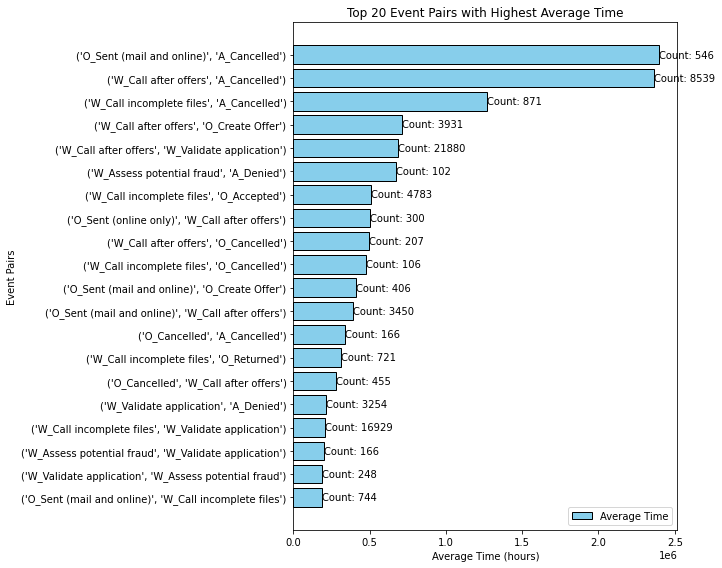

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

df = pd.read_csv('./data/BPI2017.csv')
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])
df = df.sort_values(by=['case:concept:name', 'time:timestamp'])
df['next_event'] = df.groupby('case:concept:name')['concept:name'].shift(-1)
df['time_diff'] = df.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds()
df_pairs = df[['case:concept:name', 'concept:name', 'next_event', 'time_diff']].copy()
df_pairs = df_pairs.dropna(subset=['next_event', 'time_diff'])
event_dict = defaultdict(list)
# Iterate over the DataFrame by 'case:concept:name'
for case, group in df_pairs.groupby('case:concept:name'):
    events = group['concept:name'].tolist()
    times = group['time_diff'].tolist()
    
    # Iterate over the events and times in each trace
    for i in range(len(events) - 1):
        # Add the time difference to the event pair's list in the dictionary
        event_dict[(events[i], events[i+1])].append(times[i+1])

# Calculate the average time difference and count for each event pair
avg_time_diff_dict_counts = {key: (sum(value)/len(value), len(value)) for key, value in event_dict.items()}

avg_time_diff_dict_counts = {key: value for key, value in avg_time_diff_dict_counts.items() if value[1] >= 100}

# Sort the dictionary by average time difference in descending order and keep only the top 20 pairs
top_20_pairs_counts = dict(sorted(avg_time_diff_dict_counts.items(), key=lambda item: item[1][0], reverse=True)[:20])

# Separate the counts and the average time differences for the plot
top_20_pairs = {key: value[0] for key, value in top_20_pairs_counts.items()}
top_20_counts = {key: value[1] for key, value in top_20_pairs_counts.items()}

# Create the bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(top_20_pairs)), list(top_20_pairs.values()), color='skyblue', edgecolor='black')

# Add the event pairs as y-tick labels
plt.yticks(range(len(top_20_pairs)), list(top_20_pairs.keys()))

# Add labels and title
plt.xlabel('Average Time (hours)')
plt.ylabel('Event Pairs')
plt.title('Top 20 Event Pairs with Highest Average Time')

# Add a legend
plt.legend([bars], ['Average Time'], loc='lower right')

# Add the counts as text on the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'Count: {top_20_counts[list(top_20_pairs.keys())[i]]}', 
             va='center', ha='left')

# Reverse the y-axis to have the pair with the highest average time at the top
plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()

In [80]:
print(len(filtered_trace_df))
print(len(trace_df))

print(len(df))

28381
31509
754062


### Read a CSV file and Discover a BPMN process

In [195]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123727 entries, 0 to 123726
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   Action                 123727 non-null  object             
 1   org:resource           123727 non-null  object             
 2   concept:name           123727 non-null  object             
 3   EventOrigin            123727 non-null  object             
 4   EventID                123727 non-null  object             
 5   lifecycle:transition   123727 non-null  object             
 6   time:timestamp         123727 non-null  datetime64[ns, UTC]
 7   case:LoanGoal          123727 non-null  object             
 8   case:ApplicationType   123727 non-null  object             
 9   case:concept:name      123727 non-null  object             
 10  case:RequestedAmount   123727 non-null  int64              
 11  FirstWithdrawalAmount  4628 non-null   

In [196]:
data.isnull().sum().sort_values(ascending=False)


OfferedAmount            119099
CreditScore              119099
Selected                 119099
MonthlyCost              119099
Accepted                 119099
NumberOfTerms            119099
FirstWithdrawalAmount    119099
OfferID                  107625
case:RequestedAmount          0
Action                        0
org:resource                  0
case:ApplicationType          0
case:LoanGoal                 0
time:timestamp                0
lifecycle:transition          0
EventID                       0
EventOrigin                   0
concept:name                  0
case:concept:name             0
dtype: int64

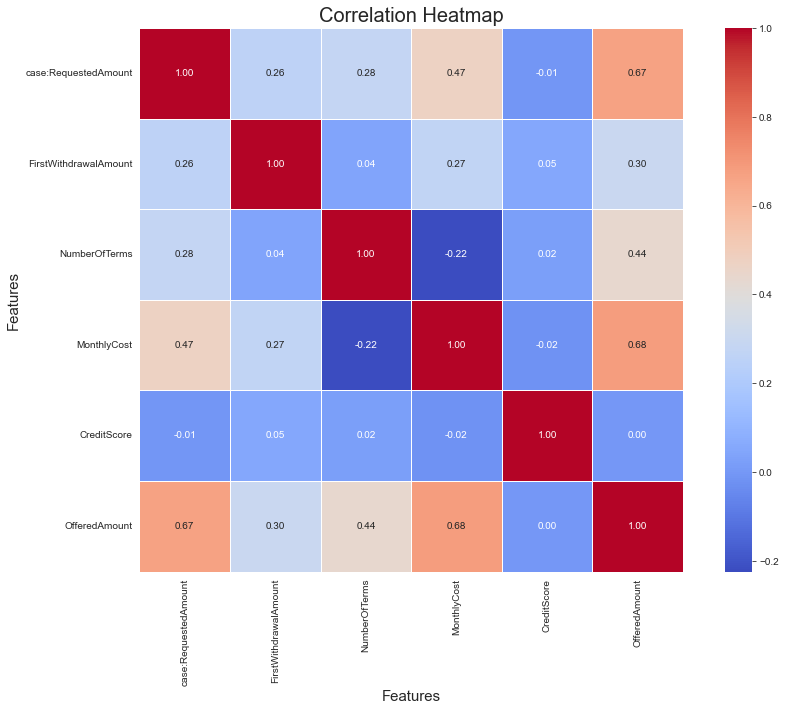

In [197]:
numeric_df = data.select_dtypes(include=['number'])
numeric_df
corr = numeric_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True,  fmt=".2f",  cmap='coolwarm', cbar=True,  square=True,  linewidths=0.5)  
plt.title('Correlation Heatmap', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)

plt.show()

### what is the frequency of offers being accepted by the bank?

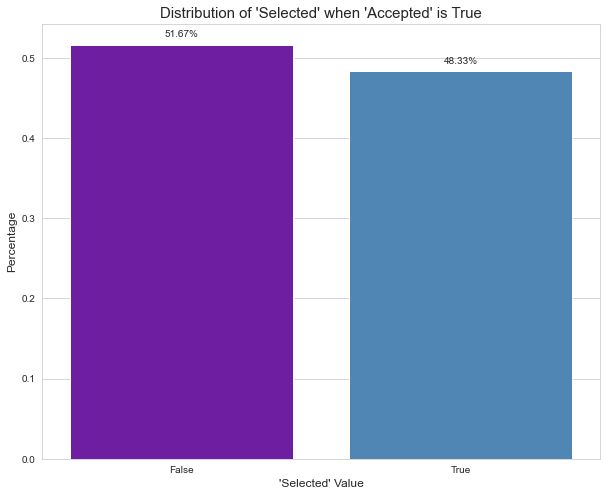

In [198]:
data['Accepted'] = data['Accepted'].astype('category')
data['Selected'] = data['Selected'].astype('category')
plt.figure(figsize=[10,8])
accepted_selected = data[data['Accepted'] == True]['Selected'].value_counts(normalize=True)
palette = ["#7209B7","#3F88C5","#136F63","#F72585","#FFBA08"]
ax = sns.barplot(x=accepted_selected.index, y=accepted_selected.values, palette=palette)
ax.set_title("Distribution of 'Selected' when 'Accepted' is True", fontsize=15)
ax.set_ylabel("Percentage", fontsize=12)
ax.set_xlabel("'Selected' Value", fontsize=12)

for i, v in enumerate(accepted_selected):
    ax.text(i, v + 0.01, '{:.2f}%'.format(v*100), horizontalalignment ='center', fontsize=10)

plt.show()


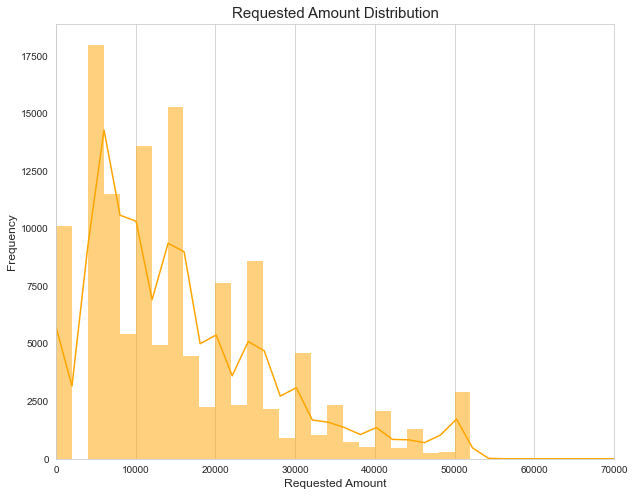

In [199]:
sns.set_style('whitegrid')
color = "orange"
plt.figure(figsize=[10,8])
sns.histplot(data['case:RequestedAmount'], bins=200, kde=True, color=color, linewidth=0)
plt.title("Requested Amount Distribution", fontsize=15)
plt.xlabel("Requested Amount", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y')
min_amount = np.min(data['case:RequestedAmount'])

plt.xlim(min_amount, 70000)  # Set x-axis limits
plt.show()

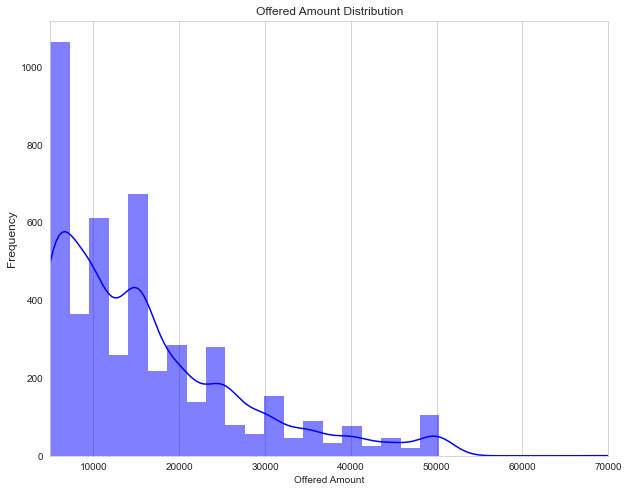

In [200]:
sns.set_style('whitegrid')
color = "blue"
plt.figure(figsize=[10,8])
sns.histplot(data['OfferedAmount'], bins=30, kde=True, color=color, linewidth=0)
plt.title("Offered Amount Distribution")
plt.xlabel("Offered Amount")
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y')
min_amount = np.min(data['OfferedAmount'])
plt.xlim(min_amount, 70000)  # Set x-axis limits
plt.show()

In [201]:
offer_data = data[data['concept:name'] == 'O_Create Offer']
columns_to_keep = ['case:RequestedAmount', 'OfferedAmount', 'case:concept:name','Selected','case:LoanGoal']  # Specify the columns you want to keep
offer_data = offer_data[columns_to_keep]
offer_data.rename(columns={'case:RequestedAmount': 'RequestedAmount', 'case:concept:name': 'CaseID','case:LoanGoal': "LoanGoal","Selected" : "Target"}, inplace=True)
offer_data = offer_data.drop_duplicates(subset='CaseID', keep='last')
outlier_threshold = 50000
offer_data = offer_data[offer_data['RequestedAmount'] <= outlier_threshold]
offer_data['ReqOfferRatio'] = offer_data['OfferedAmount'] / offer_data['RequestedAmount']



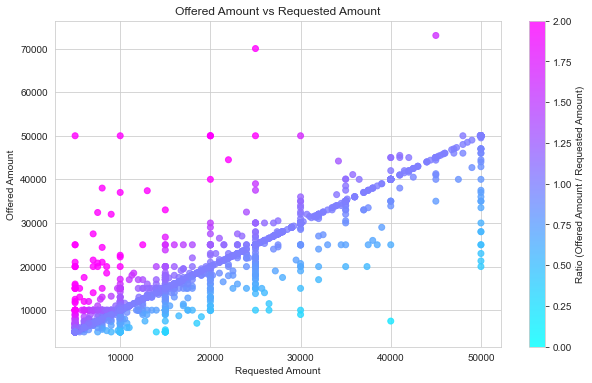

In [202]:

plt.figure(figsize=(10, 6))
plt.scatter(offer_data['RequestedAmount'], offer_data['OfferedAmount'], c=offer_data['ReqOfferRatio'], cmap='cool', alpha=0.8, vmin=0, vmax=2)
plt.title('Offered Amount vs Requested Amount')
plt.xlabel('Requested Amount')
plt.ylabel('Offered Amount')
plt.colorbar(label='Ratio (Offered Amount / Requested Amount)')
plt.show()


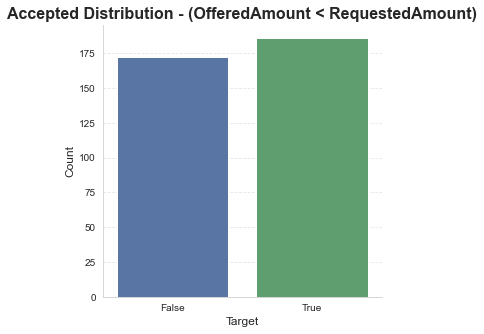

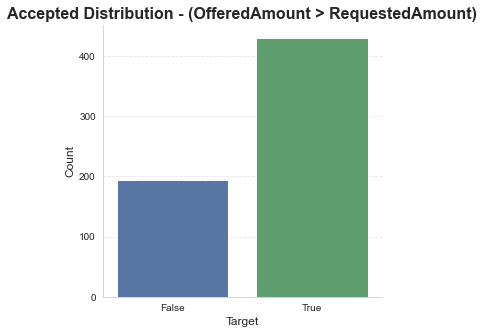

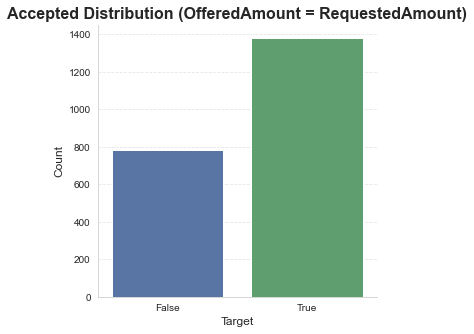

In [203]:
offer_data['Target'] = offer_data['Target'].astype('category')
offered_less = offer_data[offer_data['OfferedAmount'] < offer_data['RequestedAmount']]
offered_more = offer_data[offer_data['OfferedAmount'] > offer_data['RequestedAmount']]
offered_eq = offer_data[offer_data['OfferedAmount'] == offer_data['RequestedAmount']]

colors = ['#4c72b0', '#55a868']

# Plot for 'OfferedAmount < RequestedAmount'
plt.figure(figsize=[5, 5])
ax = sns.countplot(data=offered_less, x='Target', palette=colors)
ax.set_title("Accepted Distribution - (OfferedAmount < RequestedAmount)", fontsize=16, fontweight='bold')
ax.set_xlabel("Target", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['False', 'True'], fontsize=10)
plt.yticks(fontsize=10)
sns.despine()  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Plot for 'OfferedAmount > RequestedAmount'
plt.figure(figsize=[5, 5])
ax = sns.countplot(data=offered_more, x='Target', palette=colors)
ax.set_title("Accepted Distribution - (OfferedAmount > RequestedAmount)", fontsize=16, fontweight='bold')
ax.set_xlabel("Target", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['False', 'True'], fontsize=10)
plt.yticks(fontsize=10)
sns.despine()  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Plot for 'OfferedAmount = RequestedAmount'
plt.figure(figsize=[5, 5])
ax = sns.countplot(data=offered_eq, x='Target', palette=colors)
ax.set_title("Accepted Distribution (OfferedAmount = RequestedAmount)", fontsize=16, fontweight='bold')
ax.set_xlabel("Target", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['False', 'True'], fontsize=10)
plt.yticks(fontsize=10)
sns.despine()  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


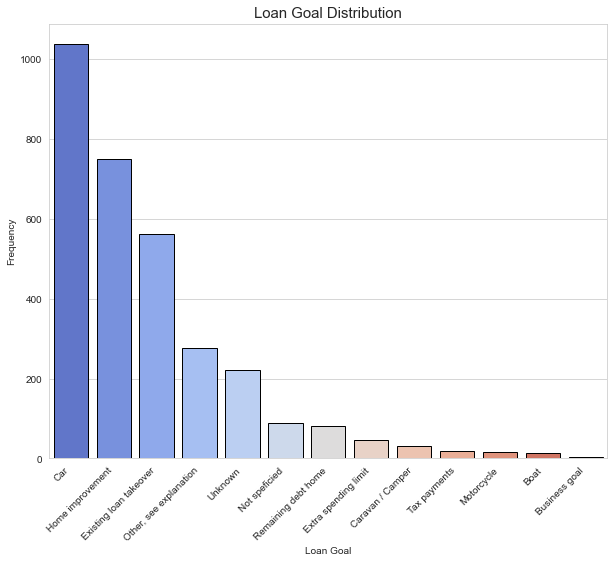

In [204]:
loan_goals_occ = offer_data['LoanGoal'].value_counts()
sns.set_style('whitegrid')
color_palette = sns.color_palette("coolwarm", len(loan_goals_occ))
plt.figure(figsize=[10,8])
ax = sns.barplot(x=loan_goals_occ.index, y=loan_goals_occ, palette=color_palette, edgecolor='black', linewidth=1)
ax.set(xlabel="Loan Goal", ylabel = "Frequency")
ax.set_title("Loan Goal Distribution", fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

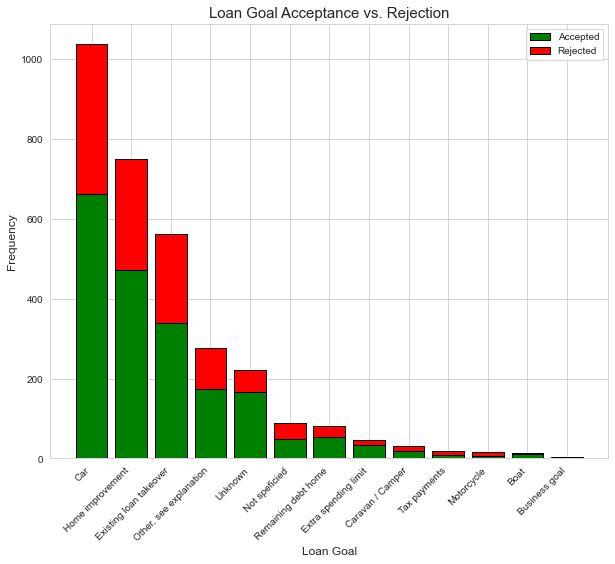

In [205]:
loan_goals_occ = offer_data['LoanGoal'].value_counts()
accepted_goals = offer_data[offer_data['Target'] == True]['LoanGoal'].value_counts()
rejected_goals = offer_data[offer_data['Target'] == False]['LoanGoal'].value_counts()
accepted_goals = accepted_goals.reindex(loan_goals_occ.index, fill_value=0)
rejected_goals = rejected_goals.reindex(loan_goals_occ.index, fill_value=0)
sns.set_style('whitegrid')
plt.figure(figsize=[10,8])
plt.bar(loan_goals_occ.index, accepted_goals, color='g', edgecolor='black', linewidth=1, label='Accepted')
plt.bar(loan_goals_occ.index, rejected_goals, bottom=accepted_goals, color='r', edgecolor='black', linewidth=1, label='Rejected')
plt.xlabel("Loan Goal", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Loan Goal Acceptance vs. Rejection", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


In [206]:
data_sorted = data.sort_values(by=['case:concept:name', 'time:timestamp'])
case_duration = data_sorted.groupby('case:concept:name')['time:timestamp'].apply(lambda x: x.max() - x.min())
case_duration
case_duration = case_duration.dt.total_seconds() / 3600  
offer_data_updated = offer_data.copy()
offer_data_updated['case_duration'] = offer_data_updated['CaseID'].map(case_duration)

In [207]:
case_event_counts = data.groupby('case:concept:name').size()

offer_data_updated['TotalEvents'] = offer_data_updated['CaseID'].map(case_event_counts)


In [208]:
offer_data_updated

,RequestedAmount,OfferedAmount,CaseID,Target,LoanGoal,ReqOfferRatio,case_duration,TotalEvents
9,20000,20000.0,Application_652823628,True,Existing loan takeover,1.00,317.965589,40
50,10000,6000.0,Application_1691306052,False,Home improvement,0.60,147.227285,31
87,15000,15000.0,Application_428409768,True,Home improvement,1.00,307.676747,45
145,5000,15700.0,Application_1746793196,True,Car,3.14,647.732610,84
208,35000,35000.0,Application_828200680,False,Home improvement,1.00,762.004580,21
...,...,...,...,...,...,...,...,...
123573,25000,25000.0,Application_4855985,True,Existing loan takeover,1.00,306.817825,28
123604,5000,5000.0,Application_1485858591,False,Home improvement,1.00,832.310181,25
123634,5000,10000.0,Application_1203711600,True,Home improvement,2.00,162.337066,32
123656,15000,15000.0,Application_1199473910,True,Car,1.00,168.142317,40


In [209]:
max_duration_index = offer_data_updated['case_duration'].idxmax()
problematic_offer = offer_data_updated.loc[max_duration_index]
print(problematic_offer)
offer_data_updated = offer_data_updated.drop(max_duration_index)

RequestedAmount                     50000
OfferedAmount                     50000.0
CaseID             Application_2011518740
Target                               True
LoanGoal           Other, see explanation
ReqOfferRatio                         1.0
case_duration                 6865.738515
TotalEvents                            55
Name: 98000, dtype: object


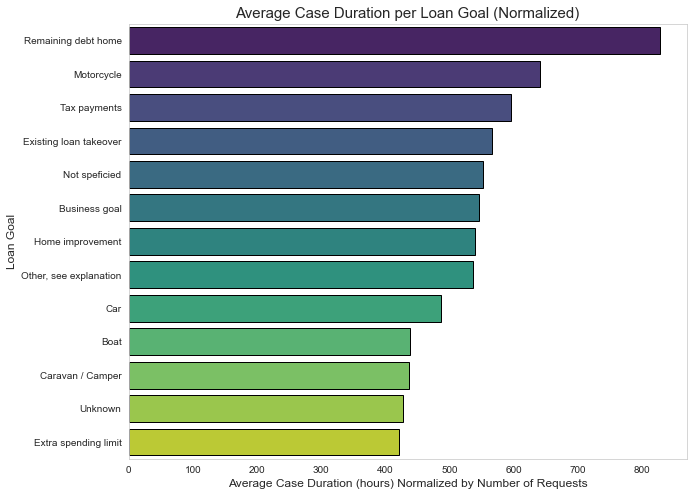

In [210]:
loan_goal_counts = offer_data_updated['LoanGoal'].value_counts()
loan_goal_duration_normalized = offer_data_updated.groupby('LoanGoal')['case_duration'].sum() / loan_goal_counts
loan_goal_duration_normalized = loan_goal_duration_normalized.sort_values(ascending=False)

plt.figure(figsize=[10,8])
sns.barplot(x=loan_goal_duration_normalized.values, y=loan_goal_duration_normalized.index, orient='h', palette='viridis', edgecolor='black')
plt.title('Average Case Duration per Loan Goal (Normalized)', fontsize=15)
plt.xlabel('Average Case Duration (hours) Normalized by Number of Requests', fontsize=12)
plt.ylabel('Loan Goal', fontsize=12)
plt.grid(axis='x')
plt.show()


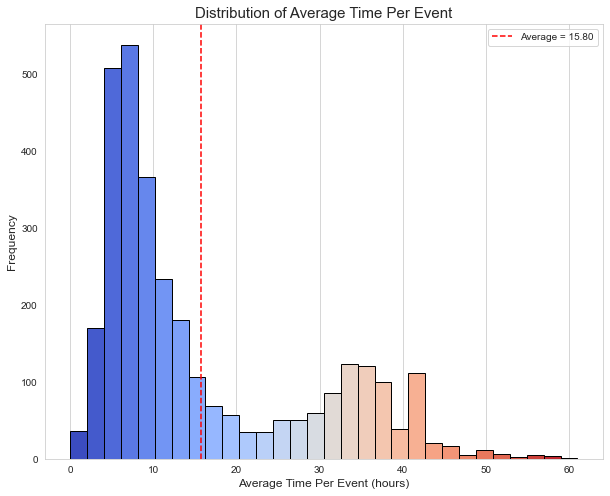

In [211]:
plt.figure(figsize=[10,8])
offer_data_updated['avg_time_per_event'] = offer_data_updated['case_duration'] / offer_data_updated['TotalEvents']

# Add a line that represents the average
avg_time_per_event = offer_data_updated['avg_time_per_event'].mean()
plt.axvline(avg_time_per_event, color='r', linestyle='dashed', linewidth=1.5, label=f"Average = {avg_time_per_event:.2f}")

# Colormap
cmap = plt.get_cmap('coolwarm')
n, bins, patches = plt.hist(offer_data_updated['avg_time_per_event'], bins=30, edgecolor='black')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap(c))

plt.title('Distribution of Average Time Per Event', fontsize=15)
plt.xlabel('Average Time Per Event (hours)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y')
plt.legend()  # Show legend for average line

plt.show()


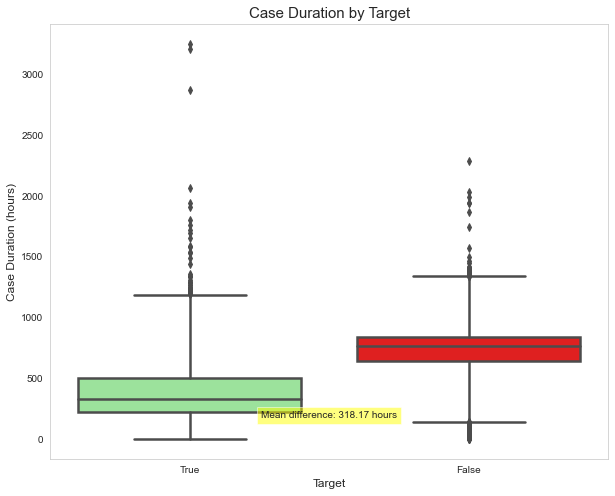

In [212]:
# Convert Target column to string
offer_data_updated['Target'] = offer_data_updated['Target'].astype(str)

plt.figure(figsize=[10,8])
sns.set_style("whitegrid")

# Use custom palette
palette = {"True": "lightgreen", "False": "red"}

# Increase the threshold for outliers (1.5 is the default)
sns.boxplot(x="Target", y="case_duration", data=offer_data_updated, palette=palette, whis=2.5, linewidth=2.5)

plt.title('Case Duration by Target', fontsize=15)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Case Duration (hours)', fontsize=12)

# Calculate the mean difference and add it to the plot
mean_diff = offer_data_updated.groupby("Target")["case_duration"].mean().diff().abs().values[-1]
plt.text(0.5, 0.1, f'Mean difference: {mean_diff:.2f} hours', 
         horizontalalignment='center',
         verticalalignment='center',
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='yellow', alpha=0.5))

plt.grid(axis='y')
plt.show()


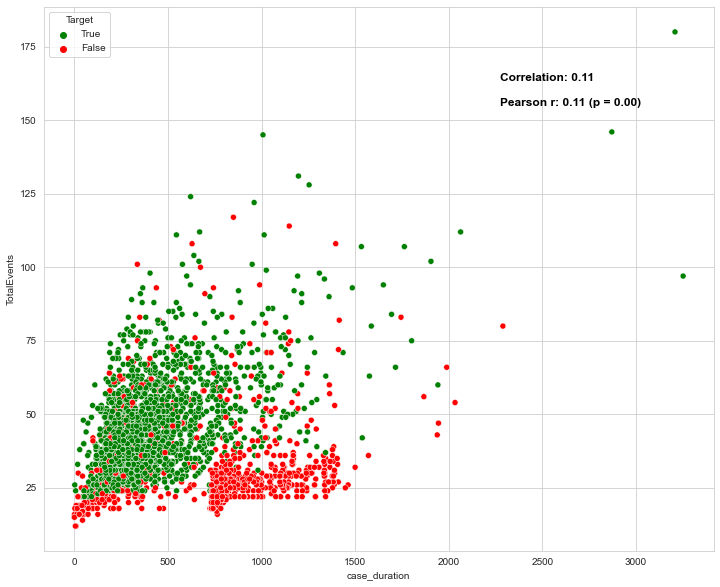

In [216]:
plt.figure(figsize=(12, 10))

# Create scatterplot
scatter_plot = sns.scatterplot(data=offer_data_updated, x="case_duration", y="TotalEvents", hue="Target", palette={"True": "green", "False": "red"})

# Calculate key statistics
avg_case_duration = offer_data_updated["case_duration"].mean()
avg_total_events = offer_data_updated["TotalEvents"].mean()
correlation = offer_data_updated["case_duration"].corr(offer_data_updated["TotalEvents"])
pearsonr = stats.pearsonr(offer_data_updated["case_duration"], offer_data_updated["TotalEvents"])

# Annotate the plot with these statistics
plt.text(offer_data_updated["case_duration"].min() + x_range*0.7, offer_data_updated["TotalEvents"].min() + y_range*0.9, f'Correlation: {correlation:.2f}', fontweight='bold', fontsize=12, color='black')
plt.text(offer_data_updated["case_duration"].min() + x_range*0.7, offer_data_updated["TotalEvents"].min() + y_range*0.85, f'Pearson r: {pearsonr[0]:.2f} (p = {pearsonr[1]:.2f})', fontweight='bold', fontsize=12, color='black')

plt.show()


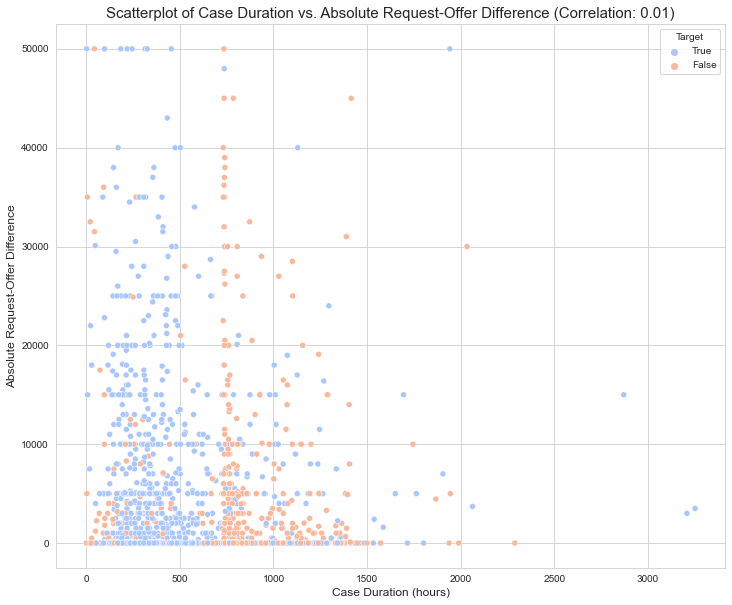

In [214]:
offer_data_updated['AbsReqOfferDiff'] = abs(offer_data_updated['RequestedAmount'] - offer_data_updated['OfferedAmount'])
plt.figure(figsize=(12, 10))
sns.scatterplot(data=offer_data_updated, x='case_duration', y='AbsReqOfferDiff', hue='Target', palette='coolwarm')
correlation = offer_data_updated['case_duration'].corr(offer_data_updated['AbsReqOfferDiff'])
plt.title(f'Scatterplot of Case Duration vs. Absolute Request-Offer Difference (Correlation: {correlation:.2f})', fontsize=15)
plt.xlabel('Case Duration (hours)', fontsize=12)
plt.ylabel('Absolute Request-Offer Difference', fontsize=12)
plt.show()


In [16]:
import pm4py
import pandas as pd
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.visualization.petri_net import visualizer as pn_visualizer


# Read the full dataset log
log = pd.read_csv('./data/BPIChallenge2017.csv')
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

# Filter top 50 variants
filtered_log = pm4py.filter_variants_top_k(log, k=50)
print(f"Number of rows after filtering top 50 variants: {len(filtered_log)}")

# Save filtered log as log_50
filtered_log.to_csv('log_50.csv', index=False)



Number of rows after filtering top 50 variants: 168106


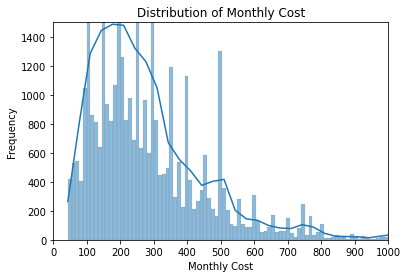

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a DataFrame
df = pd.read_csv('./data/BPIattributes.csv')

# Extract the 'MonthlyCost' column from the DataFrame
monthly_cost = df['MonthlyCost']

# Plot the histogram to visualize the distribution
sns.histplot(monthly_cost, kde=True)
plt.xlabel('Monthly Cost')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Cost')

# Set x-axis and y-axis limits
plt.xlim(0, 1000)
plt.ylim(0, 1500)
num_ticks = 11  # Adjust the number of ticks as desired
plt.xticks(range(0, 1001, 100))

plt.show()


In [124]:
import pandas as pd
df_attributes1 = pd.read_csv('./data/BPIattributes.csv')
df_attributes = df_attributes1[df_attributes1['MonthlyCost'] > 95]
df_attributes.to_csv('./data/BPI2017Loaninfo.csv', index=False)
print((df_attributes.shape[0])/(df_attributes1.shape[0]))



0.951668798697523


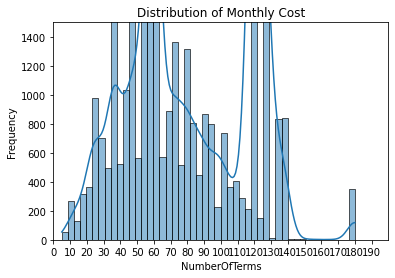

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a DataFrame
df = pd.read_csv('./data/BPIattributes.csv')

# Extract the 'MonthlyCost' column from the DataFrame
monthly_cost = df['NumberOfTerms']

# Plot the histogram to visualize the distribution
sns.histplot(monthly_cost, kde=True)
plt.xlabel('NumberOfTerms')
plt.ylabel('Frequency')
plt.title('Distribution of NumberOfTerms')

# Set x-axis and y-axis limits
plt.xlim(0, 200)
plt.ylim(0, 1500)
num_ticks = 15  # Adjust the number of ticks as desired
plt.xticks(range(0, 200,10))

plt.show()


In [125]:
df_attributes1 = pd.read_csv('./data/BPI2017Loaninfo.csv')
df_attributes = df_attributes1[df_attributes1['NumberOfTerms'] > 25]
df_attributes.to_csv('./data/BPI2017Loaninfo.csv', index=False)
df_attributes2 = pd.read_csv('./data/BPIattributes.csv')

print((df_attributes.shape[0])/(df_attributes2.shape[0]))


0.9054541225723921


In [126]:


df_loan_info = pd.read_csv("./data/BPI2017Loaninfo.csv")
df_offer = pd.read_csv('./data/BPIChallenge2017.csv')

# Get the unique loan application names from the loan info file
loan_application_names = df_loan_info['case:concept:name'].unique()

# Filter the offer file to keep only the matching loan applications
df_filtered_offer = df_offer[df_offer['case:concept:name'].isin(loan_application_names)]

# Save the filtered offer file to a new CSV
df_filtered_offer.to_csv('./data/BPI2017Filtered.csv', index=False)

In [127]:
df_2017 = pd.read_csv('./data/BPIChallenge2017.csv')
df_filter = pd.read_csv('./data/BPI2017Filtered.csv')


In [128]:
print(df_2017.shape)
print(df_filter.shape)


(1202267, 20)
(1097447, 20)


In [138]:
import pm4py
import pandas as pd
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.visualization.petri_net import visualizer as pn_visualizer


# Read the full dataset log
log = pd.read_csv('./data/BPI2017Filtered.csv')
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

# Filter top 250 variants
filtered_log = pm4py.filter_variants_top_k(log, k=250)
print(f"Number of rows after filtering top 250 variants: {len(filtered_log)}")


# Save filtered log as log_250
filtered_log.to_csv('./data/log_250.csv', index=False)


Number of rows after filtering top 3000 variants: 270765


In [133]:
df_50 = pd.read_csv('./data/log_50.csv')
df_50 = df_50[~df_50['concept:name'].str.contains('O_Returned')]


In [139]:
df_250 = pd.read_csv('./data/log_250.csv')
df_250 = df_250[~df_250['concept:name'].str.contains('O_Returned')]


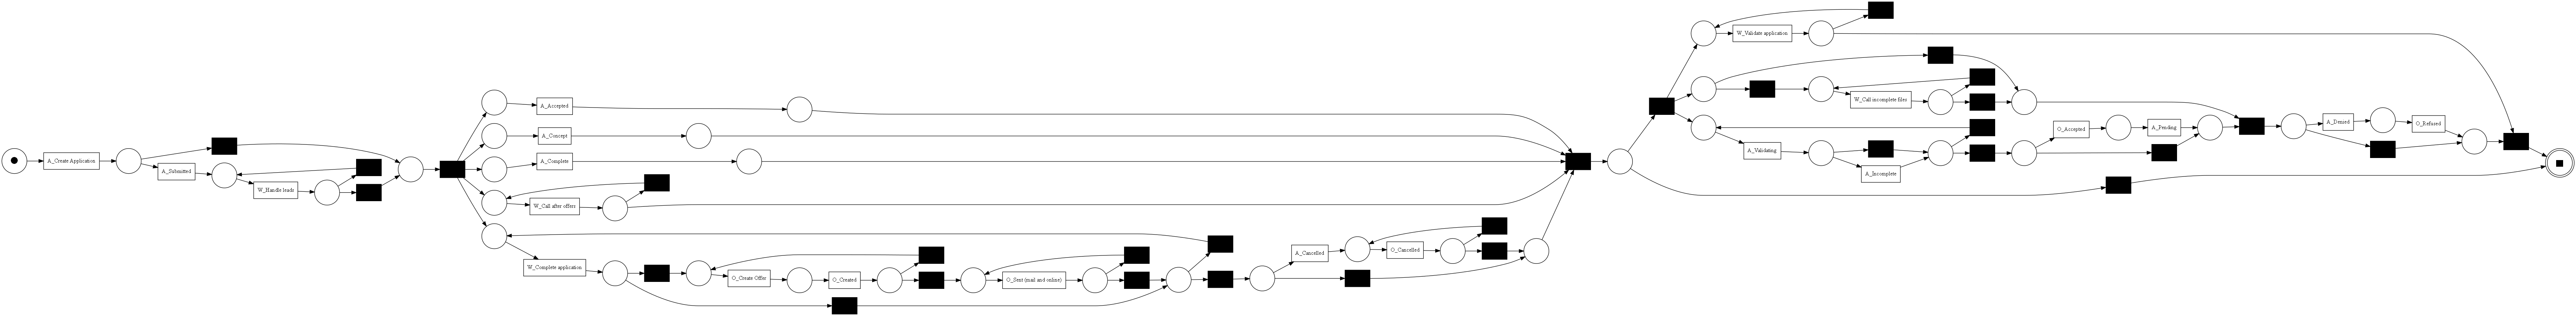

In [23]:
log_50 = log_converter.apply(df_50)
net50I,im50I,fm50I = pm4py.discover_petri_net_inductive(log_50)
pm4py.view_petri_net(net50I, im50I, fm50I)

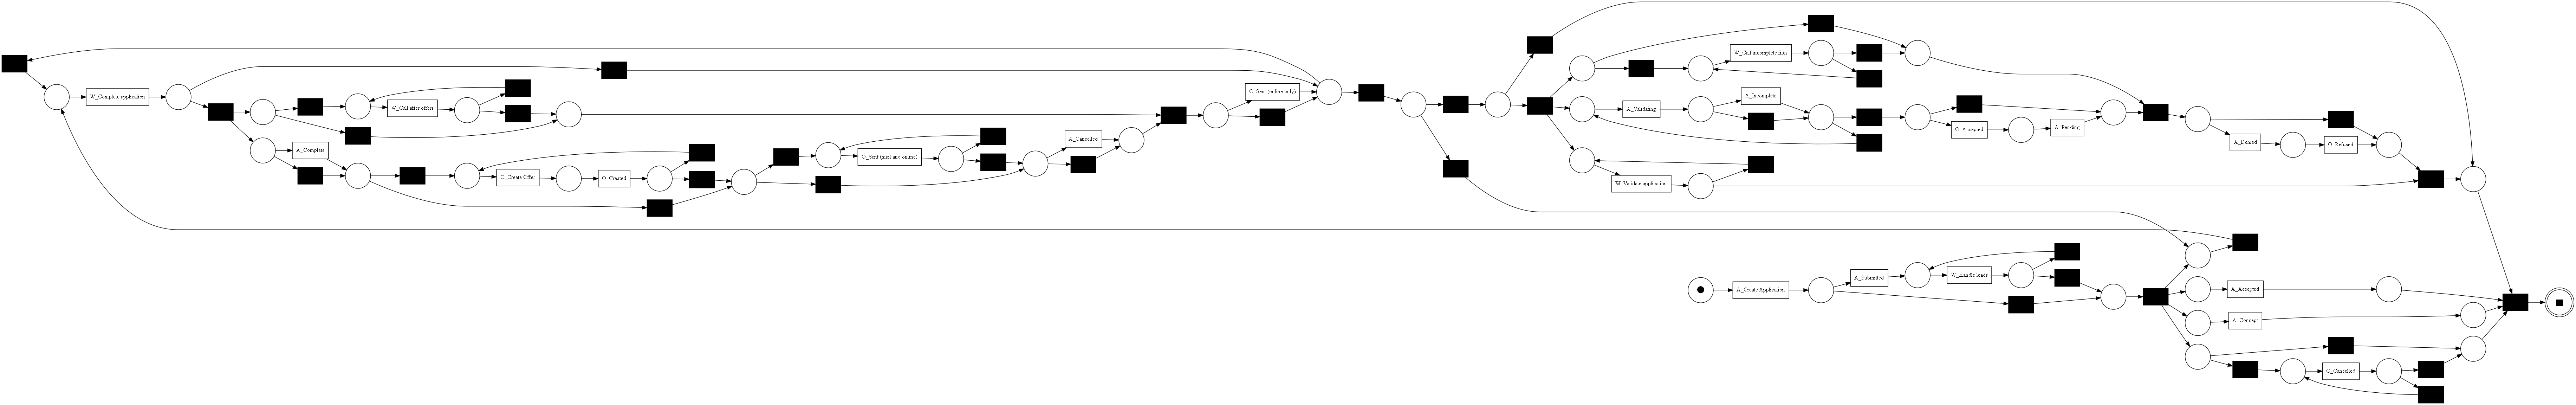

In [140]:
log_250 = log_converter.apply(df_250)
net250I,im250I,fm250I = pm4py.discover_petri_net_inductive(log_250)
pm4py.view_petri_net(net250I, im250I, fm250I)

In [143]:
pm4py.write_pnml(net250I,im250I,fm250I, 'pn1.pnml')

In [146]:
df_2017 = pd.read_csv('./data/BPIChallenge2017.csv')
log_2017 = log_converter.apply(df_2017)
net300I,im300I,fm300I = pm4py.read_pnml('pn1.pnml')
tbr1_fitness = pm4py.fitness_token_based_replay(log_2017, net300I,im300I,fm300I, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
tbr1_fitness

replaying log with TBR, completed variants ::  17%|█████                         | 2703/15930 [00:14<01:16, 172.20it/s]


replaying log with TBR, completed variants ::  29%|████████▊                     | 4694/15930 [00:28<01:25, 131.20it/s]


replaying log with TBR, completed variants ::  42%|████████████▋                 | 6753/15930 [00:43<01:08, 134.12it/s]


replaying log with TBR, completed variants ::  55%|█████████████████▏             | 8809/15930 [00:58<01:36, 73.66it/s]


replaying log with TBR, completed variants ::  68%|███████████████████▋         | 10824/15930 [01:13<00:42, 120.85it/s]


replaying log with TBR, completed variants ::  81%|███████████████████████▎     | 12825/15930 [01:27<00:21, 142.66it/s]


replaying log with TBR, completed variants ::  94%|███████████████████████████▎ | 14986/15930 [01:41<00:05, 165.99it/s]


replaying log with TBR, completed variants :: 100%|█████████████████████████████| 15930/15930 [01:47<00:00, 147.90it/s]


{'perc_fit_traces': 86.13412041004158,
 'average_trace_fitness': 0.9977547422404396,
 'log_fitness': 0.9973909777076979,
 'percentage_of_fitting_traces': 86.13412041004158}